A remake of the bar-and-whisker plot of statistical significance for the RDA paper based on RDA_bars_with_whiskers, but rewritten in much better style and to take advantage of more efficient loading of data.

In [1]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from shutil import copy

In [2]:
data_file = 'Data/decadal_stats.hdf'
results_df = pd.read_hdf(data_file)
results_df = results_df.sort_index().sort_index(axis=1)

In [30]:
#customized script that adds overbars to indicate time periods, and then on top of that a p-value for the significance of the change.
def add_pvals(fig,ax,rects_in,errs_list,pvals_list):
    
    #reorders rectangles so that we're dealing with group of 3 rectangles for each time period at same time
    zipped_rects = zip(rects_in[0],rects_in[1],rects_in[2])
    
    #get y-axis limits
    yax = ax.get_ylim()
    yhgt = yax[1]-yax[0]
    
    #add p-values sequentially to each group of 3 columns
    for rects,errs,pvals in zip(zipped_rects,errs_list,pvals_list):
        
        ##each rects group contains 3 bars - 1st bar is for '51-'79 and is wider, 2nd is '80-'93 and 3rd is '94-'07
        heights = [ rect.get_height() + err for rect,err in zip(rects,errs) ]
        max_height = max(heights[0],heights[1],heights[2])

        ## figure out x and y coordinates of brackets that are placed above bars
        xx_l = [rects[0].get_x() + rects[0].get_width()/2, rects[1].get_x() + rects[1].get_width()/2]
        xx_r = [ xx_l[0] + rects[0].get_width(), xx_l[1] + rects[1].get_width() ]
        yy = [max_height + .01*yhgt, max_height + .13*yhgt]
        bracket_widths = [1.25,.625]
        
        for x_l, x_r, y, bwidth, pval in zip(xx_l, xx_r, yy, bracket_widths, pvals):
            ##add brackets
            ax.annotate("", xy=(x_l, y + .015*yhgt), xytext=(x_l, y + .025*yhgt), 
                fontsize=15, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB='+str(bwidth)+', lengthB=.5', lw=1.0))

            ax.annotate("", xy=(x_r, y + .015*yhgt), xytext=(x_r, y + .025*yhgt), 
                fontsize=15, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB='+str(bwidth)+', lengthB=.5', lw=1.0))

            #add extra line
            ax.plot([x_l, (x_l+x_r)/2], [y + .022*yhgt, y + .045*yhgt], 'k-', lw=1)
            ax.plot([x_r, (x_l+x_r)/2], [y + .022*yhgt, y + .045*yhgt], 'k-', lw=1)

            #add p-value
            font = FontProperties()
            font.set_size('large')
            
            if abs(pval-.5) > .475:
                font.set_weight('bold')
                if abs(pval-.5) > .495:
                    font.set_style('italic')
            if pval > .999:
                message = 'p>.999'
            elif pval < .001:
                message = 'p<.001'
            else:
                message = "p={0:.3f}".format(round(pval,3))

            ax.text((x_l+x_r)/2, y + .06*yhgt, message, horizontalalignment = 'center', fontproperties = font)

In [31]:
N = 6               # number of data entries
ind = np.arange(N)              # the x locations for the groups
width1 = 0.35                   # bar width
width2 = 0.175

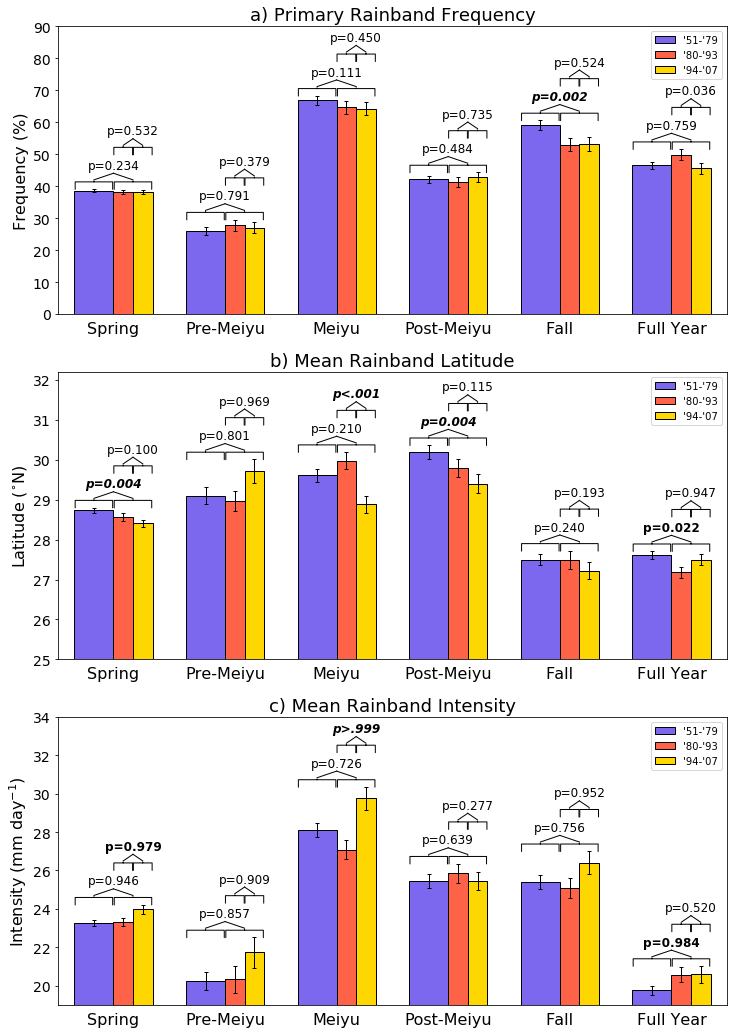

In [32]:
fig, axes = plt.subplots(3,1,figsize=(12,18), facecolor='w')
rects = []

## Parameters for subplots
colors = ['MediumSlateBlue','Tomato','Gold']
metrics = ['frequency','latitude','intensity']
my_error_kw={'ecolor':'Black', 'linewidth':1, 'capsize':2}
periods = ['p1','p1','p2']
subplot_titles = ['a) Primary Rainband Frequency','b) Mean Rainband Latitude','c) Mean Rainband Intensity']
widths = [width1, width2, width2]
xpositions = [ind-(width1/2),ind+(width2/2),ind+(3*width2/2)]
yaxis_labels = ['Frequency (%)','Latitude ($^{\circ}$N)','Intensity (mm day$^{-1}$)']
year_tags = ['8007_5179','9407_8093','9407_8093']
yranges = [[0,.9],[25,32.2],[19,34]]


for ax,met,title,ylabel,yrange in zip(axes,metrics,subplot_titles,yaxis_labels,yranges):
    
    #list of all 3 bar plots for a given subpanel
    sub_rects = []
    
    ## Plot set of bars for each time period
    for (color, p, width, xpos, yr_tag) in zip(colors, periods, widths, xpositions, year_tags):
        vals = results_df.loc[(met,'mean_'+p),(slice(None),yr_tag)].values
        errs = results_df.loc[(met,'std_'+p),(slice(None),yr_tag)].values
        sub_rects.append(ax.bar(xpos,vals,width, color=color, yerr=errs, error_kw=my_error_kw,\
                               edgecolor='black'))
    
    ## Tweak plot formatting
    ax.legend((sub_rects[0], sub_rects[1], sub_rects[2]), ("'51-'79", "'80-'93", "'94-'07"))
    ax.set_title(title, fontsize=18)
    ax.set_xlim([-.5,5.5])
    ax.set_xticks(xpositions[0]+width1/2)
    ax.set_xticklabels(('Spring', 'Pre-Meiyu', 'Meiyu', 'Post-Meiyu', 'Fall','Full Year'),\
                        fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_ylim([yrange[0],yrange[1]])

    ## Turn off x-axis ticks
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')         # ticks along the top edge are off
    
    ## Change default size of y-axis tick labels
    ax.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=14)         # ticks along the top edge are off
    
    rects.append(sub_rects)
    
    ## collect the right collection of errors and p-values necessary for plotting.
    sub_errs = []
    sub_pvals = []
    
    for season in list(results_df.columns.levels[0]):
        
        ## arrange errors
        bar_errs = []
        for (p, yr_tag) in zip(periods,year_tags):
            bar_errs.append(results_df.loc[(met,'std_'+p),(season,yr_tag)])
        
        sub_errs.append(bar_errs)
        sub_pvals.append(list(results_df.loc[(met,'pval'),(season,slice(None))].values))

    #add p-values to top of plots
    add_pvals(fig,ax,sub_rects,sub_errs,sub_pvals)
  
## Change y-axis labels from frequency to percentage in subplot a
axes[0].set_yticklabels(np.linspace(0,90,10).astype(int))

#plt.tight_layout()

In [33]:
## SAVE FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "bars.pdf"

savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath, bbox_inches='tight')
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath, bbox_inches='tight')